<a href="https://colab.research.google.com/github/sechronus22/RF-with-Quartile-pattern-bootstrapping/blob/main/BootstrappingNumeric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source : https://www.journaldev.com/45580/bootstrap-sampling-in-python

## Sample data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from random import choices
from sklearn.datasets import make_moons
from collections import Counter
from imblearn.datasets import make_imbalance
from scipy.spatial import distance_matrix
import time
import math

### Generate imbalanced data by defining range of minority and majority for each attribute

In [ ]:
def class_iden(label): 
    """
    Identify majority class and minority class for binary class data

    Parameters
    ----------
    data : dataframe
        an input dataframe
        class_col : str
          a class column of data

    Returns:
        minor_class : a minority class of data
        major_class : a majority class of data
    """

    unique, counts = np.unique(label, return_counts=True)
    minor_idx, major_idx = np.argmin(counts), np.argmax(counts)
    return unique[minor_idx], unique[major_idx]

In [ ]:
def data_dist(data,class_col):
    """
    Show scatter plot for each class (Only for 2 attributes data).

    The maximum class for plot is 14.

    Parameters
    ----------
    data : dataframe
        an input dataframe
    class_col : str
        a class column of data

    Returns
    -------
    None
    """  

    class_list = pd.unique(data[class_col]).tolist()
    color_list = ['#FF0000','#00FF00','#0000FF','#FFFF00','#FF00FF','#00FFFF', '#808080','#800000','#808000',
                  '#008000','#800080','#008080','#000080','#000000']
    for i,e in enumerate(class_list):
      data_i = data[data[class_col]==e] 
      plt.scatter(data_i['Att1'],data_i['Att2'],color=color_list[i])
    
    plt.show()

## Bootstrapping

### Bootstrapping method

In [ ]:
samp_size = 1000
bootstrap_size = 100

In [ ]:
def sampling(data,label,s_size):
    """
    Random samples from the data with size s_size

    Parameters
    ----------
    data : numpy array
        a data to do sampling
    label : numpy array
        a label of data
    s_size : int
        number of samples to sampling

    Returns
    -------
    data[sampling_index,:] : array of data from sampling
    label[sampling_index] : array of label from sampling
    """
    n = data.shape[0]
    sampling_index = np.random.choice(n,s_size)
    return data[sampling_index,:],label[sampling_index]
 

In [ ]:
X = np.arange(3000).reshape((1000,-1))
y = np.random.randint(2,size=1000)

In [ ]:
# Xs, ys = sampling(X,y,100)
# print(Xs)
# print(ys)

[[1137 1138 1139]
 [1020 1021 1022]
 [2820 2821 2822]
 [ 819  820  821]
 [2352 2353 2354]
 [2613 2614 2615]
 [2136 2137 2138]
 [2595 2596 2597]
 [ 528  529  530]
 [2832 2833 2834]
 [1530 1531 1532]
 [ 729  730  731]
 [ 645  646  647]
 [1539 1540 1541]
 [2901 2902 2903]
 [1467 1468 1469]
 [1287 1288 1289]
 [ 327  328  329]
 [1254 1255 1256]
 [ 705  706  707]
 [1200 1201 1202]
 [1557 1558 1559]
 [1719 1720 1721]
 [1122 1123 1124]
 [1974 1975 1976]
 [ 294  295  296]
 [2694 2695 2696]
 [1374 1375 1376]
 [2958 2959 2960]
 [ 828  829  830]
 [ 477  478  479]
 [ 636  637  638]
 [2805 2806 2807]
 [ 348  349  350]
 [ 171  172  173]
 [2061 2062 2063]
 [2079 2080 2081]
 [1023 1024 1025]
 [ 486  487  488]
 [ 345  346  347]
 [1503 1504 1505]
 [1509 1510 1511]
 [2088 2089 2090]
 [2070 2071 2072]
 [ 966  967  968]
 [1671 1672 1673]
 [1614 1615 1616]
 [2931 2932 2933]
 [1770 1771 1772]
 [ 459  460  461]
 [1176 1177 1178]
 [2025 2026 2027]
 [1380 1381 1382]
 [ 303  304  305]
 [ 459  460  461]
 [2100 210

In [ ]:
def bootstrap(data,label,s_size,b_size):
    """
    Random samples from the data with size s_size for b_size times

    Parameters
    ----------
    data : numpy array
        a data to do sampling
    label : numpy array
        a label of data
    s_size : int
        number of samples to sampling
    b_size : int
        number of bootstrapping

    Returns
    -------
    [sampling(data,s_size) for _ in range(b_size)] : list
        a list of data from sampling 
    """
    return [sampling(data,label,s_size) for _ in range(b_size)]

## Weighted Bootstrapping

https://pynative.com/python-weighted-random-choices-with-probability/

### Mass-ratio-variance outlier factor (MOF)

1. Euclidean distance
$$d(p,q)=\sqrt{\sum_{i=1}^{n} (p_i-q_i)^2}$$

In [ ]:
def euclid_distance(p1,p2):
  return np.sqrt(np.sum(np.square(p1 - p2)))

2. Neighborhood : Neighborhood of point q respect to point p
$$N_p (q)=\{o\in D|d(q,o)\leq d(q,p)\}$$

In [ ]:
def Neighborhood(arr):
    """
    Compare the pairwise distances between two elements and count the number 

    of neighborhood (points that the distance is lower than or equal to the interesting point)

    including the interesting point

    Ex arr = [2,3,6,1,8] -> nbh = [2,3,4,1,5]

    Parameters
    ----------
    arr : numpy array
        a 1-dimensional array which each element are distance

    Returns
    -------
    nbh : numpy array
        an array which each element is the number of neighborhood of that point
    """
    arr_size = len(arr)
    n_arr = arr.reshape((1,arr_size))
    distance_diff = n_arr-n_arr.T
    nbh = np.sum(np.where(distance_diff>=0,1,0),axis=0)
    return nbh

In [ ]:
def NBH_Matrix(data):
    """
    Compute the pairwise distances between two points and find the number of neighborhood

    of point q respect to point p for all pair (p,q)

    Ex arr = [[906 892]
              [870 323]
              [433 480]
              [602 695]
              [569 849]]
      
      Neighbor_matrix =  [[1 4 5 3 2]
                          [4 1 3 2 5]
                          [5 4 1 2 3]
                          [4 5 3 1 2]
                          [3 5 4 2 1]]

    Parameters
    ----------
    data : numpy array
        a 2-dimensional array which each row is a data point

    Returns
    -------
    Neighbor_matrix : numpy array
        a matrix which element [i,j] represent the number of neighborhood of point i respect to point j 
    """
    d_size = len(data)
    dist_matrix = distance_matrix(data,data)
    # print(dist_matrix)
    Neighbor_matrix = np.ones((d_size,d_size))
    Neighbor_matrix = np.apply_along_axis(Neighborhood, 1, dist_matrix)
    return Neighbor_matrix

**Note** q is row and p is column

3. Mass ratio : mass ratio of point q respect to point p
$$Mass_p (q) = \frac{|N_p (q)|}{|N_q (p)|}$$

In [ ]:
def MassRatio(data):
    """
    Compute the mass ratio of all pairwise data points

    Parameters
    ----------
    data : numpy array
        a 2-dimensional array which each row is a data point

    Returns
    -------
    Neighbor_matrix : numpy array
        mass ratio of all pairwise data points
    """
    minor_NBH_matrix = NBH_Matrix(data)
    return minor_NBH_matrix/np.transpose(minor_NBH_matrix)

In [ ]:
def MOF_p(pre_arr,i):
  arr = np.delete(pre_arr,i,axis=0)
  return np.var(arr)

def MOF(data):
    """
    Compute the mass ratio variance of all data points

    Parameters
    ----------
    data : numpy array
        a 2-dimensional array which each row is a data point

    Returns
    -------
    MRV_matrix : numpy array
        an array of mass ratio variance of all data points
    """
    MR_Matrix = MassRatio(data)
    d_size = len(data)
    MRV_Matrix = np.zeros(d_size)
    for i in range(d_size):
      MRV_Matrix[i] = MOF_p(MR_Matrix[:,i],i)

    return MRV_Matrix

## Stratified Bootstrapping
* Generate population
* Random samples from population
* do bootstrapping on sample set by
  * For each class
    * Calculate MOF
    * Sort data with MOF and divide into quartile
    * Do random sampling on each quartile
* Compare the structure of result with the structure of population
* Tries to change the partition to decile, percentile 
* Tires to increase number of class

 **Note** : 
 1. number of sample in each class is up to class ratio. 
 
 Ex. class A : class B=0.1:0.9 and we want to sample 1000 instances    >> sampling 100 from A and 900 from B
 2. In each class, sampling in each quartile are equal
 
 Ex. We sampling 25 samples from each quartile of class A and sampling 225 samples from each quartiles of class B
 

### Generate population and random sample set
* more RGB color : https://www.rapidtables.com/web/color/RGB_Color.html

In [ ]:
# generate 2 attribute sample set with n class
def pop_gen(p_size, class_ratio):
  class_no = len(class_ratio)
  size_per_class = int(p_size//class_no)
  class_size = [int(e*p_size) for e in class_ratio]
  max_val = 2*p_size
  att1_list = []
  att2_list = []
  class_list = []
  for i in range(class_no):
    # random attribute range
    # print("class",i)
    att1_min =  random.randint(0,int((1-class_ratio[i])*max_val))
    att1_max = att1_min + class_ratio[i]*max_val/2
    # print(att1_min, att1_max)
    att2_min =  random.randint(0,int((1-class_ratio[i])*max_val))
    att2_max = att2_min + class_ratio[i]*max_val/2
    # print(att2_min, att2_max)

    att1_list += [random.randint(att1_min,att1_max) for i in range(class_size[i])]
    att2_list += [random.randint(att2_min,att2_max) for i in range(class_size[i])]
    class_list += [i]*class_size[i]
  data1 = {"Att1":att1_list,
            "Att2":att2_list,
            "Class":class_list}
  sample_df = pd.DataFrame(data1)
  return sample_df

### Quartile-pattern bootstrapping

Input : data, column name of class, sample_size

Output : sampling data

* sampling_data = [ ]
* Divide data into minor_data, major_data
* Calculate MOF score of minor_data 
* Sort minor_data acccording to MOF score -> sort_minor_data
* Divide sort_minor_data into q1_data, q2_data, q3_data, q4_data
* add q4_data to sampling data
* merge q2_data and q3_data -> q23_data
* sampling data from q23_data with size len(q23_data)/2 and add to sampling_data
* sample_size = sample_size-len(q1_data)-len(q23_data)/2
* Add add q1_data to major_data
* Sampling data from major_data with size sample_size and add to sampling_data
* return sampling data


In [ ]:
def quartile_partition(data):
  '''
  Compute MOF, sort data and divide data in to quartile, then return list of index of data in each quartile
  '''
  MOF_list = MOF(data)
  d_size = len(data)
  q1_t, q2_t, q3_t = int(d_size/4),int(2*d_size/4), int(3*d_size/4)
  # Ex d_size =10 [0:9] >> [0,1],[2,3,4],[5,6],[7,8,9]
  # Ex d_size =10000 [0:9999] >> [0:2499],[2500:4999],[5000,7499],[7500:9999]
  MOF_sort = np.argsort(MOF_list).tolist()
  q1_idx, q2_idx, q3_idx, q4_idx = MOF_sort[:q1_t], MOF_sort[q1_t:q2_t], MOF_sort[q2_t:q3_t], MOF_sort[q3_t:]
  return q1_idx, q2_idx, q3_idx, q4_idx

In [ ]:
def qp_bootstrapping(data,label,s_size, b_size):
  # define minor class and major class
  minor_class, major_class = class_iden(label)
  # create sampling dataframe
  col_size = data.shape[1]
  bootstrap_list = []

  # divide data according to class
  minor_data = data[np.where(y==minor_class),:]
  major_data = data[np.where(y==major_class),:]
  # divide minority data into 4 groups
  q1_idx, q2_idx, q3_idx, q4_idx = quartile_partition(minor_data)
  q1_data, q2_data, q3_data, q4_data = minor_data[q1_idx,:], minor_data[q2_idx,:], minor_data[q3_idx,:], minor_data[q4_idx,:]

  # merge q2 and q3, merge q4 and major data
  q23_data = np.append(q2_data, q3_data)
  q4major_data = np.append(major_data, q4_data)

  # bootstrapping
  for i in range(b_size):
    sampling_data = np.copy(q4_data) # add all q4_data



  return bootstrap_list

In [ ]:
def strat_sampling2(data,class_col,s_size):
  # define minor class and major class
  min_class, maj_class = class_iden(data, class_col)
  # create sampling dataframe
  col_name = data.columns.values.tolist()
  sampling_df = pd.DataFrame(columns=col_name)
  d_size = len(data)
  # divide data according to class
  minor_df = data[data[class_col]==min_class].reset_index(drop=True)
  major_df = data[data[class_col]==maj_class].reset_index(drop=True)
  # divide minority data into 4 groups
  minor_matrix = minor_df.drop(columns=[class_col]).to_numpy()
  q1_idx, q2_idx, q3_idx, q4_idx = quartile_partition(minor_matrix)
  # add all 1st quartile data to sampling df
  sampling_df = sampling_df.append(minor_df.iloc[q1_idx])
  s_size = s_size-len(q1_idx)

  # sampling half of q2 and q3 and add to sampling df
  q23_df = minor_df.iloc[q2_idx+q3_idx]
  sampling_df = sampling_df.append(sampling(q23_df,int(len(q23_df)/2)))
  s_size = s_size-int(len(q23_df)/2)

  # add q4 to major df and do sampling
  major_df = major_df.append(minor_df.iloc[q4_idx]).reset_index(drop = True)
  sampling_df = sampling_df.append(sampling(major_df,s_size))

  
  # ignore index
  sampling_df = sampling_df.reset_index(drop = True)
  return sampling_df.apply(pd.to_numeric)

In [ ]:
def strat_bootstrap2(data,class_col,s_size, b_size):
  return [strat_sampling2(data,class_col,s_size) for _ in range(b_size)]

### 2-class data Test 

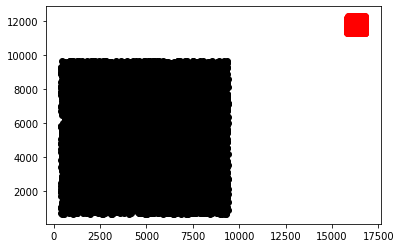

In [ ]:
# # generate population
# population = pop_gen(10000, [0.9,0.1])
# data_dist(population, 'Class')

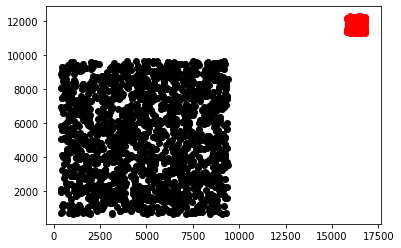

In [ ]:
# # samples data
# sample_set = sampling(population,2000)
# data_dist(sample_set,'Class')

In [ ]:
# sample_set.groupby('Class')['Class'].count()

Class
0    1796
1     204
Name: Class, dtype: int64

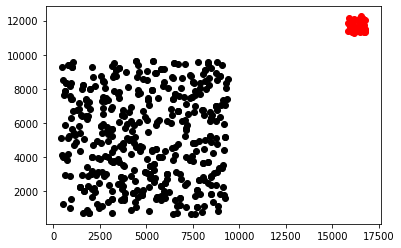

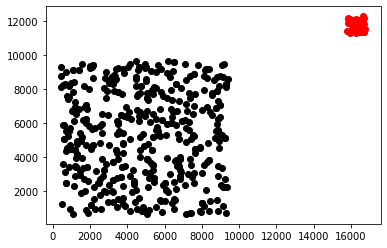

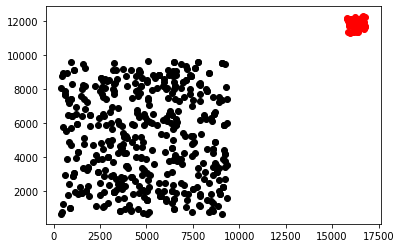

In [ ]:
# # do bootstrapping
# s_bootstrap_list = strat_bootstrap(sample_set,'Class',500, 3)
# for i in range(3):
#   data_dist(s_bootstrap_list[i],'Class')

### 4-class data Test 

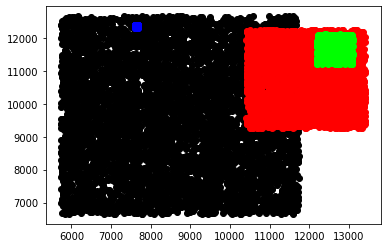

In [ ]:
# # generate population
# population = pop_gen(10000, [0.6,0.3,0.09,0.01])
# data_dist(population, 'Class')

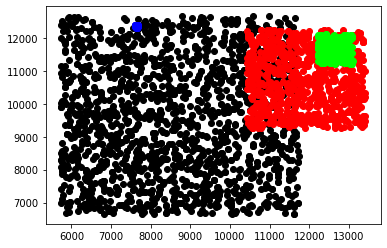

In [ ]:
# # samples data
# sample_set = sampling(population,3000)
# data_dist(sample_set,'Class')

In [ ]:
# sample_set.groupby('Class')['Class'].count()

Class
0    1773
1     927
2     256
3      44
Name: Class, dtype: int64

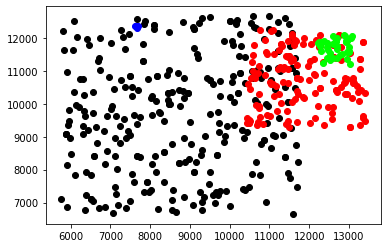

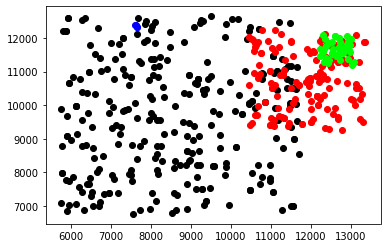

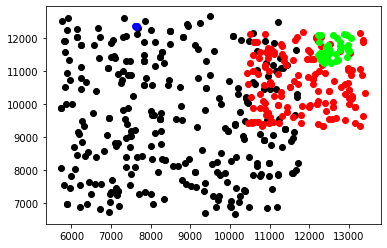

In [ ]:
# # do bootstrapping
# s_bootstrap_list = strat_bootstrap(sample_set,'Class',500, 3)
# for i in range(3):
#   data_dist(s_bootstrap_list[i],'Class')

## Note

* data = d (10000)
* sample size = s (1000)
* minor ratio = r (0.01)
* minor sample = rs (10)
* minor data = rd (100)
* MOF
  * 10% = 0.1rd (10) >> take all >> s-0.1rd (990) samples to random
  * 40% = 0.4rd (40) >> take half >> s-0.3rd (970) samples to random
  * 50% = 

In [ ]:
# a = %timeit strat_sampling(population,'Class',500)

KeyboardInterrupt: ignored

### sampling on make_moons data

In [ ]:
from sklearn.datasets import make_blobs, make_moons
from collections import Counter
from imblearn.datasets import make_imbalance
import pandas as pd

ssize = 1800
# X_maj, y_maj = make_blobs(n_samples=maj_size, centers=[(0,0)], n_features=2,random_state=0)
# X_min, y_min = make_blobs(n_samples=min_list, centers=cluster_center, cluster_std=0.5, n_features=2,random_state=0)
# df_4c = pd.DataFrame(data={'Att1':np.append(X_maj[:, 0],X_min[:, 0]),'Att2':np.append(X_maj[:, 1],X_min[:, 1]),
#                          'target':np.append(y_maj,[1]*min_size)})   

X, y = make_moons(n_samples=ssize, noise=0.2)
df_moon = pd.DataFrame(data={'Att1':X[:, 0],'Att2':X[:, 1],
                         'target':y})   

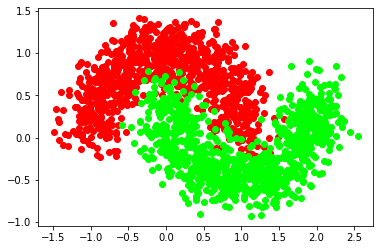

In [ ]:
# data_dist(df_moon,'target')

In [ ]:
# Counter(y)

Counter({1: 900, 0: 900})

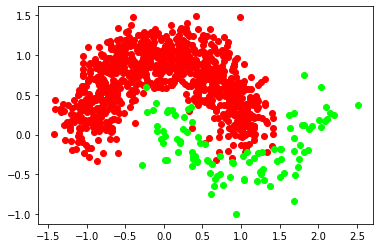

In [ ]:
X_res, y_res = make_imbalance(X, y,sampling_strategy={0: 900, 1: 100},random_state=42)
df_moon2 = pd.DataFrame(data={'Att1':X_res[:, 0],'Att2':X_res[:, 1],
                         'target':y_res}) 
data_dist(df_moon2,'target') 

Counter({0: 148, 1: 52})


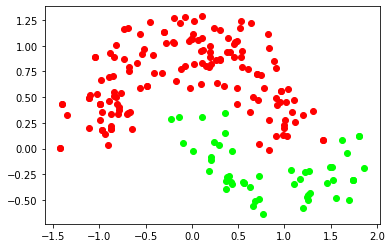

Counter({0: 146, 1: 54})


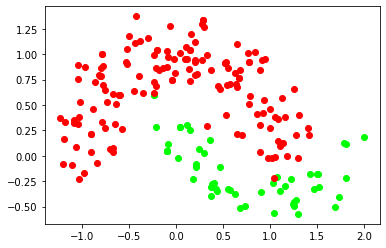

Counter({0: 146, 1: 54})


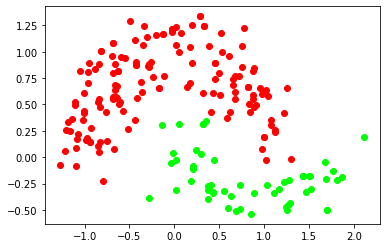

Counter({0: 147, 1: 53})


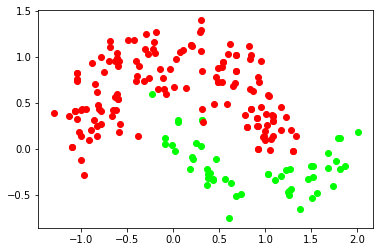

Counter({0: 148, 1: 52})


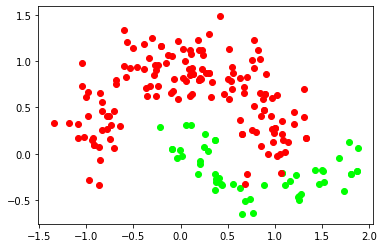

In [ ]:
s_bootstrap_list = strat_bootstrap2(df_moon2,'target',200, 5)
for i in range(5):
  print(Counter(s_bootstrap_list[i].target))
  data_dist(s_bootstrap_list[i],'target')

Counter({0: 180, 1: 20})


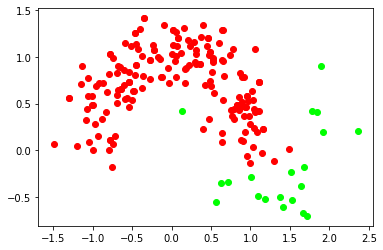

Counter({0: 180, 1: 20})


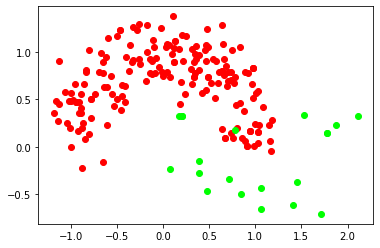

Counter({0: 180, 1: 20})


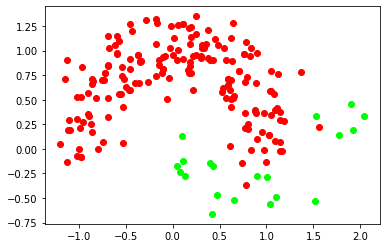

In [ ]:
# s_bootstrap_list = strat_bootstrap(df_moon2,'target',200, 5)
# for i in range(5):
#   print(Counter(s_bootstrap_list[i].target))
#   data_dist(s_bootstrap_list[i],'target')

Counter({0: 181, 1: 19})


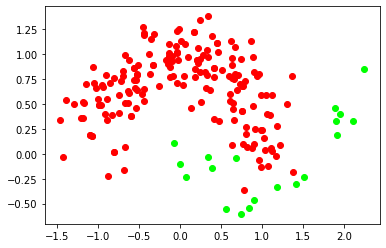

Counter({0: 177, 1: 23})


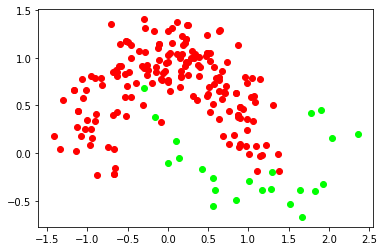

Counter({0: 175, 1: 25})


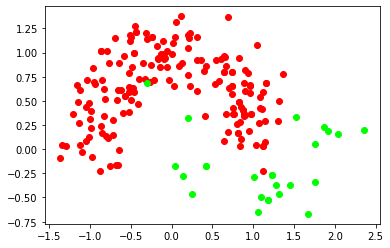

Counter({0: 179, 1: 21})


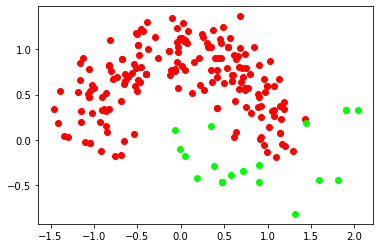

Counter({0: 187, 1: 13})


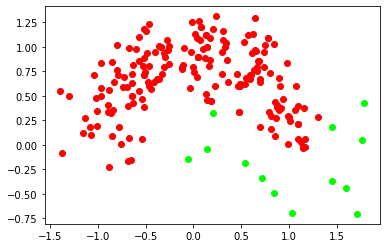

In [ ]:
# s_bootstrap_list2 =bootstrap(df_moon2,200, 5)
# for i in range(5):
#   print(Counter(s_bootstrap_list2[i].target))
#   data_dist(s_bootstrap_list2[i],'target')
  

In [ ]:
# min_class, maj_class = class_iden(df_moon2, 'target')
# minor_df = df_moon2[df_moon2['target']==min_class].reset_index(drop=True)
# minor_matrix = minor_df.drop(columns=['target']).to_numpy()
# MOF_minor = MOF(minor_matrix)

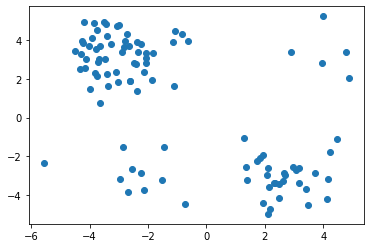

In [ ]:
# plt.scatter(X_min[:,0],X_min[:,1])
# plt.show()

In [ ]:
# sorted(MOF_minor)

[0.02628459000425541,
 0.02642137650388076,
 0.028892497898805117,
 0.030036105496182786,
 0.031320865646352704,
 0.031525453604455585,
 0.033279104647764506,
 0.0356529831552954,
 0.037235437949843214,
 0.03727067023446039,
 0.03990536515576744,
 0.03993109879689827,
 0.04176247551143222,
 0.04235988958034258,
 0.04238718292158125,
 0.043524307625028756,
 0.04403752308326644,
 0.044423220691305894,
 0.045964745428201906,
 0.047112891651780446,
 0.0500139241442768,
 0.05066924643224239,
 0.05186167290747369,
 0.05238804933256831,
 0.05332459974702671,
 0.05342252223200038,
 0.05374486803698946,
 0.05390844633060293,
 0.05463967534591093,
 0.056486014293490025,
 0.057965306023532184,
 0.059109919105177586,
 0.059918397164134996,
 0.06120709761728268,
 0.06186642059042069,
 0.06216510167834943,
 0.06240678458754512,
 0.06442141690377222,
 0.0652996018429653,
 0.06810944621737279,
 0.07365835289713164,
 0.07487289858952335,
 0.07504093017316944,
 0.07710730752432166,
 0.07783529301757094,

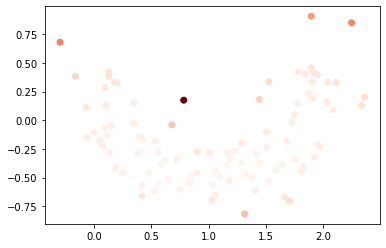

In [ ]:
# plt.scatter(minor_matrix[:,0],minor_matrix[:,1],c=MOF_minor,cmap='Reds')
# plt.show()

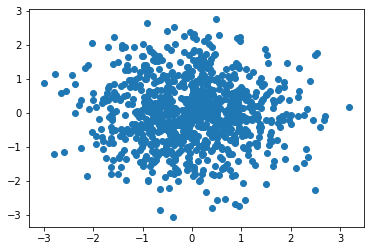

In [ ]:
# plt.scatter(X_maj[:,0],X_maj[:,1])
# plt.show()

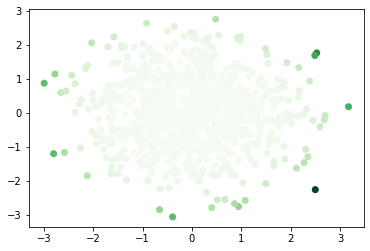

In [ ]:
# MOF_major = MOF(X_maj)
# plt.scatter(X_maj[:,0],X_maj[:,1],c=MOF_major,cmap='Greens')
# plt.show()